---
title: "Python でスキャン画像の回転補正をやってみる"
date: 2025-03-25
categories: [Python, image]
---


画像の回転補正をやってみる。

### 準備

安全運転BOOKの目次のスキャン画像を使います。

(『安全運転BOOK』伊藤印刷株式会社)

In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

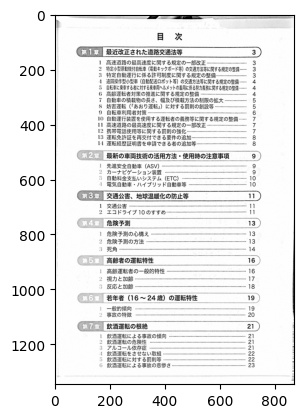

In [2]:
img = cv2.imread("sample.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [3]:
def rotate_image(img: np.ndarray, d: float, border_value: int = 1, resize=False):
    """
    画像を d [度] 回転します。

    Args:
        img:
        d: 回転角度
        border_value: 余白を埋める値
        resize: True のとき、回転後の画像が欠けないようにサイズ調整をします
                False のときはもとのサイズと同じ画像が返ります
    """
    height, width = img.shape[:2]
    new_width, new_height = width, height
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, d, 1)

    if resize:
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # 回転後のすべての領域が含まれるサイズを計算
        new_width = int(width * cos + height * sin)
        new_height = int(width * sin + height * cos)
        # 中心ずらし
        M[0, 2] += (new_width - width) / 2.0
        M[1, 2] += (new_height - height) / 2.0

    affine_img = cv2.warpAffine(img,
                                M,
                                (new_width, new_height),
                                borderMode=cv2.BORDER_CONSTANT,
                                borderValue=border_value)
    return affine_img


傾けた画像を用意する

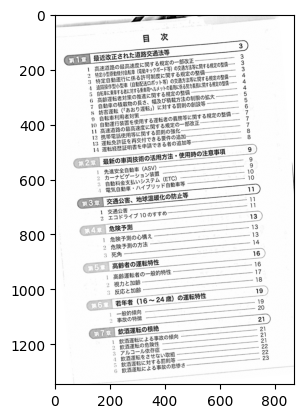

In [4]:
img = rotate_image(img,5,255)
plt.imshow(img, cmap='gray')

### 回転補正

以下のサイトの射影ヒストグラムをもとに最も良い「正面度」となる角度を探索し、画像を回転させる。

[射影ヒストグラムを用いた文書画像の回転補正 - 社会人研究者が色々頑張るブログ](https://nsr-9.hatenablog.jp/entry/2021/08/09/200559)  

In [5]:
def projection_histogram(bimg):
    """
    射影ヒストグラムの作成
    https://nsr-9.hatenablog.jp/entry/2021/08/09/200559
    """
    bimg = np.ones_like(bimg) - bimg
    out = np.sum(bimg, axis=1)
    return out


def to_binary_adavtive_threshold(img: np.ndarray) -> np.ndarray:
    """2値化処理 {0, 1} に変換"""
    
    bimg = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 50
    )
    bimg[bimg == 255] = 1
    return bimg

In [6]:
bimg=to_binary_adavtive_threshold(img)
hist = projection_histogram(bimg)

ヒストグラムの確認

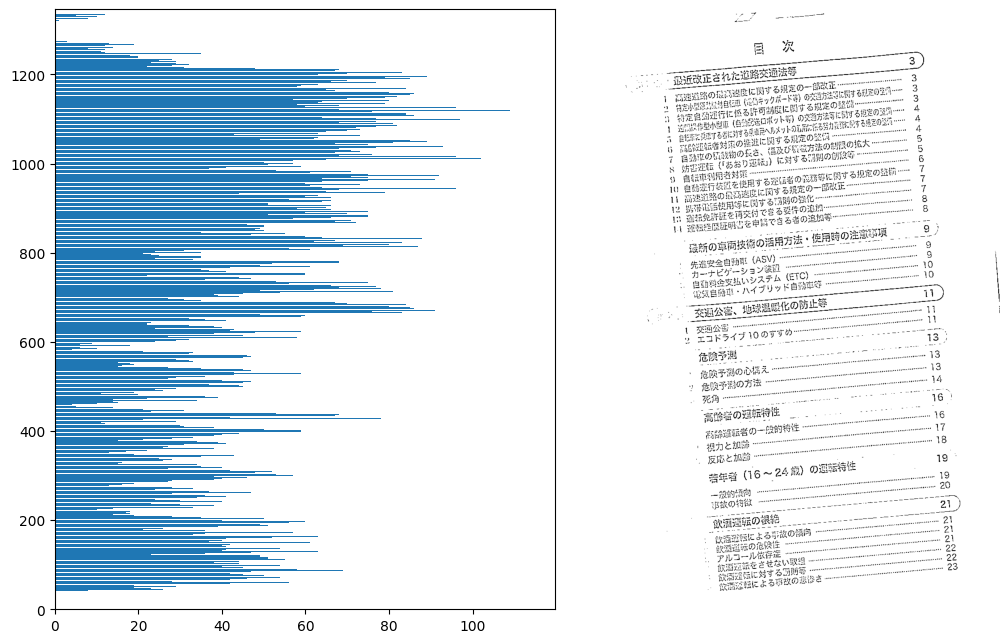

In [7]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

# histgram
ax0 = fig.add_subplot(gs[0])
val = hist[::-1]
x = range(len(val))
ax0.barh(x, val)
ax0.set_ylim(0, len(val))

# image
ax1 = fig.add_subplot(gs[1])
ax1.imshow(bimg, cmap="gray")
ax1.axis("off")
plt.subplots_adjust(wspace=0, left=0, right=1, top=1, bottom=0)
plt.show()

In [8]:
def calc_cost(img:np.ndarray,d:float):
    img=rotate_image(img,d,border_value=1,resize=True)
    hist=projection_histogram(img)
    hist=np.where(hist<=1,0,1)
    return np.sum(hist)

calc_cost(bimg,0.)

1249

角度を変えたときのコストの変化を確認する

In [9]:
x=np.linspace(-8., 8, num=80)
vals=[calc_cost(bimg,d) for d in x]

In [10]:
min_idx=0
for i in range(len(vals)):
    if vals[i]<vals[min_idx]:
        min_idx=i

In [11]:
print("コスト最小値となる角度:",x[min_idx])

コスト最小値となる角度: -4.962025316455696


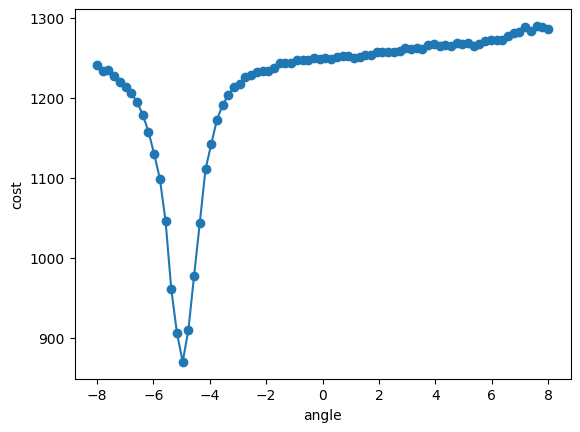

In [12]:
plt.xlabel('angle')
plt.ylabel('cost')
plt.plot(x, vals, marker='o')  
plt.show()

探索した良い正面度の角度に補正する

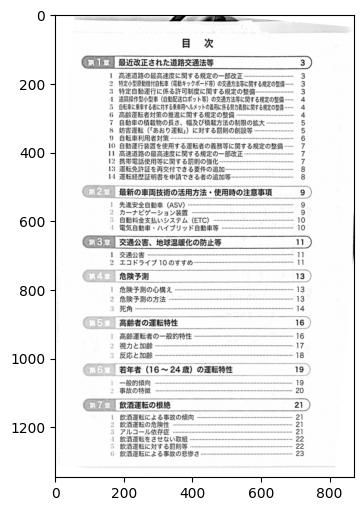

In [13]:
tmp=rotate_image(img,x[min_idx],border_value=255)
fig = plt.figure(figsize=(10, 6))
plt.imshow(tmp, cmap='gray')

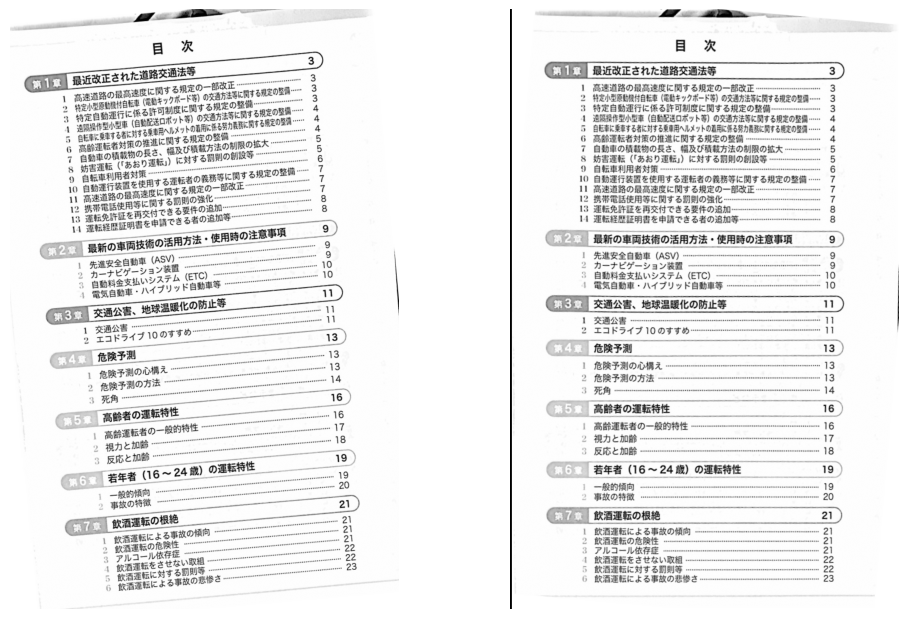

In [14]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])

ax0=fig.add_subplot(gs[0])
ax0.imshow(img, cmap='gray')
ax0.axis('off')

ax1=fig.add_subplot(gs[1])
ax1.imshow(tmp, cmap='gray')
ax1.axis('off')
plt.subplots_adjust(wspace=0, left=0, right=1, top=1, bottom=0)

# 縦線を追加
ax1.axvline(x=0, color='black', linewidth=2)   
plt.show()

### おまけ

ぱっとわからなかった回転後の画像サイズの求め方  
![回転後の画像サイズ](imagesize.jpeg)